### RNN Notebook

### Python Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.layers import Embedding, SimpleRNN, Dense
from itertools import cycle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import emoji
import nltk
import re

In [ ]:
start_time = time.time()

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Data Cleaning & Preprocessing

In [ ]:
df_rnn = pd.read_csv('/content/drive/MyDrive/RNN Script/Original_Data.csv')

<ipython-input-7-4dc90820f360>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rnn = pd.read_csv('/content/drive/MyDrive/RNN Script/Original_Data.csv')


In [ ]:
df_rnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259900 entries, 0 to 259899
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   business            259900 non-null  object 
 1   review_title        259900 non-null  object 
 2   date_of_experience  259900 non-null  object 
 3   review_date         259900 non-null  object 
 4   review_rating       231430 non-null  object 
 5   review_text         259900 non-null  object 
 6   page_number         259898 non-null  float64
 7   review_text_length  259898 non-null  float64
 8   sentiment_polarity  259898 non-null  float64
 9   sentiment_label     259898 non-null  object 
 10  review_year         259898 non-null  float64
dtypes: float64(4), object(7)
memory usage: 21.8+ MB


In [ ]:
# Check for NaN values
nan_in_data = df_rnn.isna().sum()
print(nan_in_data)

business                  0
review_title              0
date_of_experience        0
review_date               0
review_rating         28470
review_text               0
page_number               2
review_text_length        2
sentiment_polarity        2
sentiment_label           2
review_year               2
dtype: int64


In [ ]:
df_rnn.drop('review_rating', axis=1, inplace=True)
df_rnn.dropna(inplace=True)

In [ ]:
# Initializing lemmatizer
lemmatizer = WordNetLemmatizer()

# function to convert emojis to text
def convert_emojis_to_text(text):
    return emoji.demojize(text)

# function to clean text
def clean_text(text):
    text = text.lower()
    text = convert_emojis_to_text(text)  # Convert emojis to text
    text = re.sub(r'[\t\n\r\(\)]', ' ', text)
    text = re.sub(r'[^a-z ]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')])
    return text

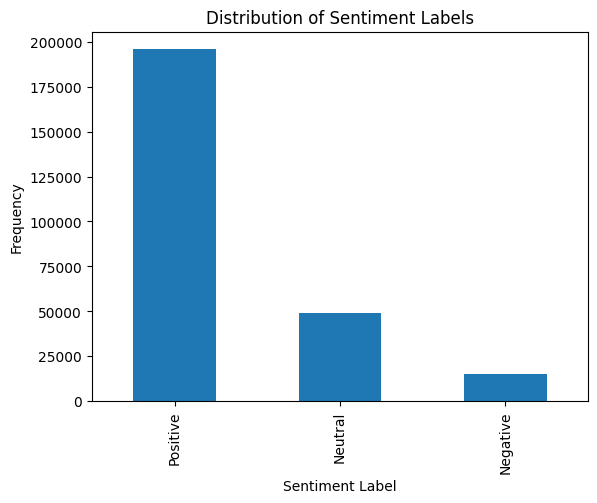

In [ ]:
class_counts = df_rnn['sentiment_label'].value_counts()

# Plotting the distribution of sentiment labels
class_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Cleaning the review texts
df_rnn['cleaned_text'] = df_rnn['review_text'].apply(clean_text)

In [ ]:
# Initializing the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_rnn['cleaned_text'])

# Converting texts to sequences
sequences = tokenizer.texts_to_sequences(df_rnn['cleaned_text'])

In [ ]:
# Determining the max sequence length and pad sequences
max_seq_length = max(len(x) for x in sequences)
X_padded = pad_sequences(sequences, maxlen=max_seq_length)

In [ ]:
# Mapping the sentiment labels to integers
sentiment_label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

# Applying the mapping to the 'sentiment_label' column
df_rnn['sentiment_label'] = df_rnn['sentiment_label'].map(sentiment_label_mapping)

In [ ]:
# Splitting the data into training and testing sets (using integer labels)
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X_padded,
    df_rnn['sentiment_label'].values,
    test_size=0.3,
    random_state=42
)

In [ ]:
# Initializing the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resampling the training data (using integer labels)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train_int)

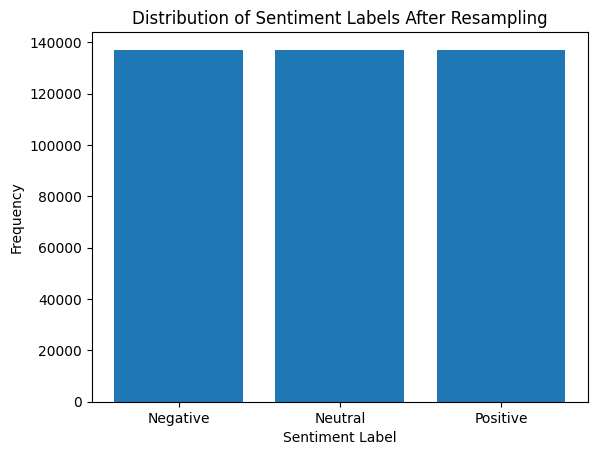

Counter({2: 137044, 0: 137044, 1: 137044})


In [ ]:
# Counting the number of instances for each sentiment label after resampling
class_distribution = Counter(y_train_resampled)

# Plotting the distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Distribution of Sentiment Labels After Resampling')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.xticks(ticks=list(sentiment_label_mapping.values()), labels=sentiment_label_mapping.keys())
plt.show()

print(class_distribution)

In [ ]:
# one-hot encoding the resampled labels
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test_int)

### Model Training

In [ ]:
# Defining the RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_seq_length))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 823, 100)          9306200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 9316955 (35.54 MB)
Trainable params: 9316955 (35.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Defining EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('rnn_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
# Training the model with EarlyStopping and ModelCheckpoint
history = model.fit(X_train_resampled, y_train_resampled_categorical, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
10279/10279 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8622
Epoch 1: val_loss improved from inf to 0.62865, saving model to rnn_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10279/10279 [==============================] - 5995s 583ms/step - loss: 0.3829 - accuracy: 0.8622 - val_loss: 0.6287 - val_accuracy: 0.7618
Epoch 2/10
10279/10279 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.9078
Epoch 2: val_loss did not improve from 0.62865
10279/10279 [==============================] - 5997s 583ms/step - loss: 0.2651 - accuracy: 0.9078 - val_loss: 0.6498 - val_accuracy: 0.7447
Epoch 3/10
10279/10279 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9113Restoring model weights from the end of the best epoch: 1.

Epoch 3: val_loss did not improve from 0.62865
10279/10279 [==============================] - 6031s 587ms/step - loss: 0.2562 - accuracy: 0.9113 - val_loss: 1.0804 - val_accuracy: 0.5445
Epoch 3: early stopping


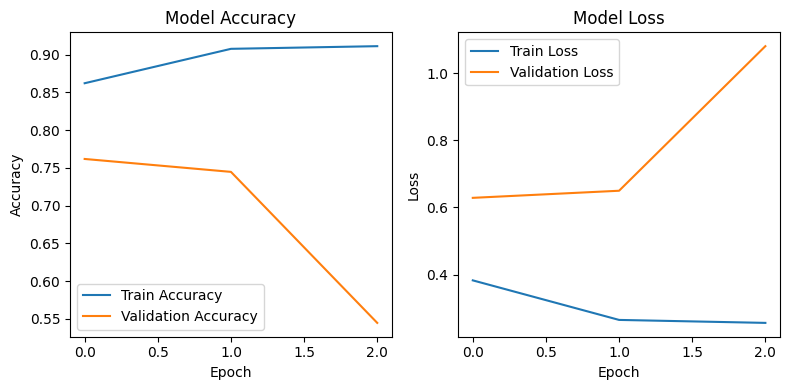

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

#### Model Evaluation

In [ ]:
# Loading the best model saved by ModelCheckpoint
best_model = load_model('rnn_best_model.h5')

# Evaluating the model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test_categorical)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2437/2437 [==============================] - 149s 61ms/step - loss: 0.3424 - accuracy: 0.8741
Test Loss: 0.34236669540405273
Test Accuracy: 0.8740925788879395


In [ ]:
# Predict the probabilities or classes
test_predictions_prob = best_model.predict(X_test)
test_predictions = np.argmax(test_predictions_prob, axis=1)

# converting y_test to categorical form
y_test_integers = np.argmax(y_test_categorical, axis=1)

# Generating classification report
print(classification_report(y_test_integers, test_predictions, target_names=['Negative', 'Neutral', 'Positive']))

2437/2437 [==============================] - 145s 59ms/step
              precision    recall  f1-score   support

    Negative       0.54      0.75      0.63      4359
     Neutral       0.70      0.68      0.69     14816
    Positive       0.95      0.93      0.94     58795

    accuracy                           0.87     77970
   macro avg       0.73      0.79      0.75     77970
weighted avg       0.88      0.87      0.88     77970



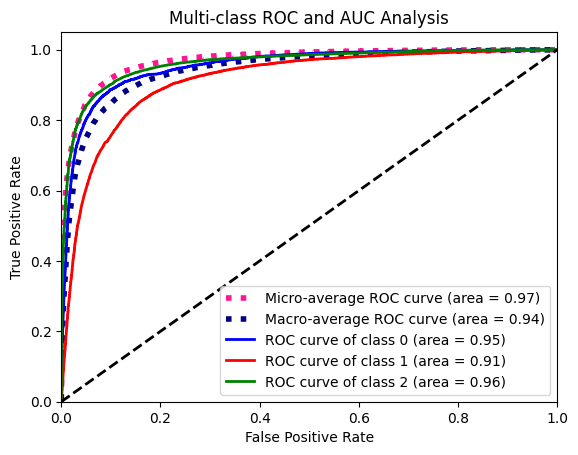

In [ ]:
# This code was modified from code obtained from https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

# Computing ROC curve and ROC area for each class
n_classes = y_test_categorical.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], test_predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# aggregating all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolating all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#  averaging and computing AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_categorical.ravel(), test_predictions_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC Analysis')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Generating a confusion matrix
cm = confusion_matrix(y_test_integers, test_predictions)

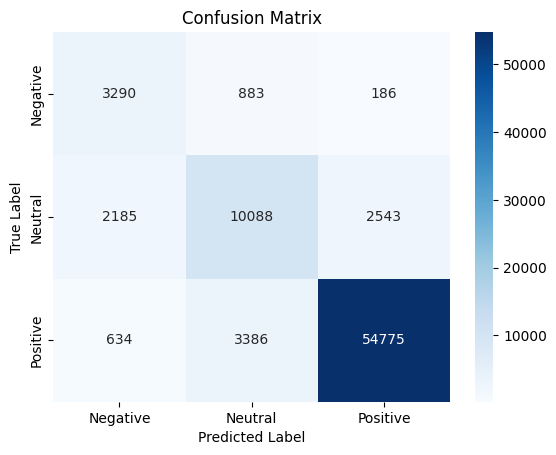

In [ ]:
# plotting confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### OOD Testing

In [ ]:
Hotel_df=pd.read_csv('/content/drive/MyDrive/LSTM Script/Datafiniti_Hotel_Reviews_Jun19.csv')

In [ ]:

Hotel_df['processed_text'] = Hotel_df['reviews.text'].apply(clean_text)

In [ ]:
def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive


# Applying the function to the 'review.rating' column to create a new 'sentiment_label' column
Hotel_df['sentiment_label'] = Hotel_df['reviews.rating'].apply(rating_to_sentiment)

In [ ]:
 #Converting texts to sequences using the tokenizer fitted on the original training data
new_sequences = tokenizer.texts_to_sequences(Hotel_df['processed_text'])

# Padding sequences to the same length training data
Hotel_df_padded = pad_sequences(new_sequences, maxlen=max_seq_length)

new_predictions = best_model.predict(Hotel_df_padded)

# Converting predictions to label indices
new_predictions_indices = np.argmax(new_predictions, axis=1)

# Adding predictions to the new dataframe
Hotel_df['predicted_sentiment'] = new_predictions_indices

# Mapping numeric predictions back to sentiment labels
sentiment_label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
Hotel_df['predicted_sentiment_label'] = Hotel_df['predicted_sentiment'].map(sentiment_label_mapping)

# Mapping from integer to string sentiment labels
int_to_str_sentiment = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Replacing integer labels with string labels in the DataFrame
Hotel_df['sentiment_label'] = Hotel_df['sentiment_label'].replace(int_to_str_sentiment)

313/313 [==============================] - 19s 60ms/step


In [ ]:
# Creating a cross-tabulation to compare actual and predicted sentiments
comparison = pd.crosstab(Hotel_df['sentiment_label'], Hotel_df['predicted_sentiment_label'])

accuracy = np.mean(Hotel_df['sentiment_label'] == Hotel_df['predicted_sentiment_label'])

print(comparison)
print('-----------------------------------------------------------------------')
print(f"Overall accuracy of sentiment prediction: {accuracy:.2f}")

predicted_sentiment_label  Negative  Neutral  Positive
sentiment_label                                       
Negative                        256      274       591
Neutral                          73      165       952
Positive                        117      364      7208
-----------------------------------------------------------------------
Overall accuracy of sentiment prediction: 0.76


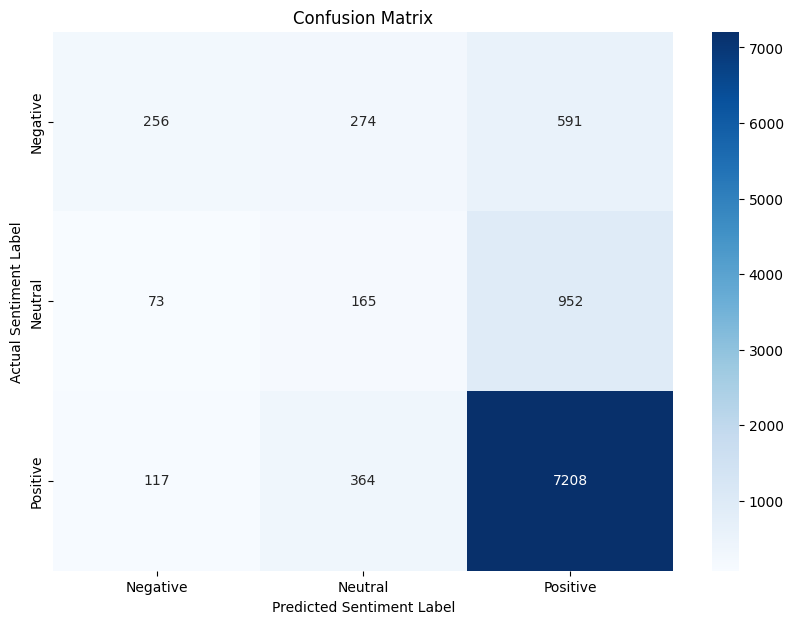

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(comparison, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Sentiment Label')
plt.ylabel('Actual Sentiment Label')
plt.show()

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken to run the script: {total_time} seconds")

Total time taken to run the script: 19155.388494968414 seconds
